## Sentence embedding: Embedding more than words with sentence transformers

This notebook shows how to use [**sentence transformers**](https://sbert.net/) to generate contextualized embeddings for longer text sequences like sentences or short paragraphs.

<br><a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/dev/notebooks/sentence_embedding_illustration.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [15]:
# check if on colab
COLAB=True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    # install required packages
    !pip install -q sentence-transformers==3.1.0 matplotlib==3.9.2 seaborn==0.13.1 umap-learn==0.5.6

if COLAB:
    data_path = 'https://raw.githubusercontent.com/haukelicht/advanced_text_analysis/refs/heads/dev/data/unlabeled/louwerse_oppoistion_2021/'
else:
    import os
    data_path = os.path.join('..', 'data', 'unlabeled', 'louwerse_oppoistion_2021', '')

In [16]:
# for data wrangling
import pandas as pd

# for document embedding
from sentence_transformers import SentenceTransformer

# for dimensionality reduction
from umap import UMAP 

# for visaualization
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
SEED = 42

## Load some example data

Here we use a corpus of sentences from speeches delivered by opposition speakers in the UK *House of Commons* in debates about COVID-19-related topics.
The data has been collected by Tom Louwerse et al. ([2021](https://doi.org/10.1080/01402382.2021.1886519)) and we have obtained the raw (annotated) speech sentences from the authors.

In [18]:
fp = data_path + 'louwerse_oppoistion_2021-uk_covid_speeches.csv'
df = pd.read_csv(fp)

In [19]:
# show first speech (split into sentence at new line character)
df.text[0].split('\n')

['I thank the Secretary of State for an advance copy of his statement, and for updating the House this morning.',
 'The coronavirus is indeed very concerning, and I am grateful for the work of Public Health England and the Department on it so far, especially in screening passengers on direct flights from Wuhan.',
 'However, a passenger arriving from Wuhan yesterday said that he had gone through virtually no screening, but was given a leaflet.',
 'Does the Secretary of State have any response to that?',
 'Will flights from other Chinese cities, not just Wuhan, be monitored, and when does the Minister think monitoring might begin?',
 'Will there be specific traveller advice for UK citizens travelling into China who have existing conditions that may mean they need to take more care?',
 'As the Minister said, Public Health England has assessed the risk of the coronavirus being spread to the UK as “low”.',
 'In the event of the virus spreading to the UK, are there contingency plans and fund

In [20]:
# split speech texts into sentences (list of strings)
df['text'] = df.text.str.split('\n')
# explode into long sentence-level data frame (like tidyr::unnest in R)
df = df.explode('text')

Let's see how long theses sentences tend to be:

In [22]:
(df.text.str.strip().str.split('\s+', regex=True).apply(len)+1).describe().astype(int)

count    4864
mean       24
std        13
min         2
25%        15
50%        22
75%        31
max       141
Name: text, dtype: int64

## Sentence embedding

In [23]:
# instantiate a sentence embedding model (source: https://www.sbert.net/docs/pretrained_models.html)
embedding_model_name = 'all-mpnet-base-v2'
embedding_model = SentenceTransformer(embedding_model_name)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**_Note:_** Check the leaderboard for sentence embedding: https://huggingface.co/spaces/mteb/leaderboard ([*source*](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers)). There you might find a model that achieves better performance or can ingest longer texts, like 'dunzhang/stella_en_400M_v5' or 'Alibaba-NLP/gte-large-en-v1.5'

#### Important 

It's important to remember that *every* transformer has a maximum number of tokens it can ingest per input document.
As the name implies, sentence embedding models works best for either sentences or paragraphs. If your texts are longer documents, they will be truncated which might results in systematic information loss.

So you should **always check** if the documents you want to embed are too long for the model you want to use.

In [24]:
# get the embedding model's max sequence length (measured in tokens)
embedding_model.max_seq_length

384

In [25]:
# tokenize your texts with the pre-trained model and get the length of each tokenized text
df['n_toks'] = embedding_model.tokenizer(df.text.tolist(), return_length=True, truncation=False).length

In [26]:
# compute share of sentences that will be truncated
(df['n_toks'] > embedding_model.max_seq_length).mean()

0.0

**_Note:_** 
If our documents are too long, read [this thread](https://www.reddit.com/r/LanguageTechnology/comments/xh71yt/comment/j4fbqti/).
They suggest to use a Transformer model with a higher max. sequence length (e.g., a "Longformer").
This you could use to create document embeddings with the huggingface `pipeline` API (see [here](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#hugging-face-transformers)). 
Alternatively, you can consider an [alternative document representation](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html) approach.

In [27]:
len(df)

4864

In [28]:
# WARNING: this will take some time (~1.5 minutes) if you use a CPU
embeddings = embedding_model.encode(df.text.tolist(), batch_size=16, show_progress_bar=True)

Batches:   0%|          | 0/304 [00:00<?, ?it/s]

## Retrieval

### Get most similar examples

In [41]:
# sample 10 sentences
expls = df.text.sample(10, random_state=SEED)
expl_embeddings = embeddings[expls.index,:]

In [50]:
from sentence_transformers.util import cos_sim
import numpy as np

# Compute cosine similarity between example embeddings and all embeddings
similarities = cos_sim(expl_embeddings, embeddings)

# Find the indices of the 10 most similar sentences for each example sentence
most_similar_indices = np.argsort(-similarities, axis=1)[:, :5]

# Retrieve the most similar sentences
most_similar_sentences = [df.text.iloc[indices].tolist() for indices in most_similar_indices]

# Display the most similar sentences for each example sentence
for i, example in enumerate(expls):
    print(f'Example sentence: "{example}"')
    print("Most similar sentences:")
    for sentence in most_similar_sentences[i]:
        print(f'- "{sentence}"')
    print()

Example sentence: "I know that the Secretary of State said that we are through the peak, but can the same be said of the care sector, given the number of deaths we have seen reported today in the care sector?"
Most similar sentences:
- "Can the Secretary of State clarify for the House what exactly the travel advice is for those travelling or seeking to travel to northern Italy?"
- "Will that guidance be changed to state that people should not be travelling to wider northern Italy, and other areas, so that people are not disadvantaged by not having travel insurance if they choose not to put themselves, and indeed all of us, at risk of the disease spreading?"
- "The Secretary of State suggested that he would not go to wider northern Italy, and the Chief Medical Officer suggested that people with health conditions should not go there."
- "Does the Secretary of State recognise the confusion there is that those returning from certain parts of north Italy must self-isolate, even if asymptoma

### Get relevant examples

In [75]:
def rank_relevance(query, embeddings, model):
    # encode the query using the embedding model
    query_embedding = model.encode([query])

    # compute cosine similarity between the query embedding and all sentence embeddings
    query_similarities = cos_sim(query_embedding, embeddings).flatten()

    # rank the sentences based on their similarity to the query
    ranked = np.argsort(-query_similarities)
    return ranked, query_similarities[ranked]

In [76]:
ranked_indices, query_similarities = rank_relevance(
    query = "Which sentence discusses consequences for ethnic minorities?",
    embeddings=embeddings,
    model=embedding_model
)

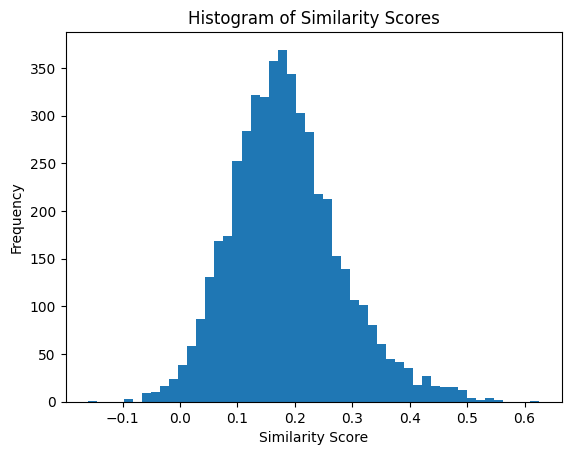

In [77]:
# Plot the histogram of similarity scores
plt.hist(query_similarities, bins=50)
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [79]:
# relative threshold: 10% most similar
r = int(len(ranked_indices)/0.10)
ranked_indices[:r]

tensor([4006, 3659, 4077,  ..., 1561, 4612, 1380])

In [82]:
# absolute threshold: similarity >= 0.5
t = sum(query_similarities >= 0.5)
ranked_indices[:t]

tensor([4006, 3659, 4077, 4143, 3619, 3842, 4008, 3908,  941, 4387, 3794, 2746,
        4480])

In [83]:
# retrieve the ranked sentences
ranked_sentences = df.text.iloc[ranked_indices].tolist()

# display the ranked sentences
top_n = t
for i, sentence in enumerate(ranked_sentences[:top_n]):
    print(f'Rank {i+1:02d}: "{sentence}"')

Rank 01: "The ethnic minority population is more likely to live in areas of deprivation—especially black, Pakistani and Bangladeshi people."
Rank 02: "Almost three quarters of health and social care staff who were battling this virus on our behalf but who subsequently died as a result of covid-19 were black, Asian and minority ethnic, so I am hoping against hope that one of the few positives to take from this national crisis is that those espousing hatred against minorities and migrants will now be ignored, and that will lead to less racism and greater community cohesion."
Rank 03: "This debate is rightly focused on the impact of coronavirus on black, Asian and minority ethnic communities—a point extremely pertinent to my constituency."
Rank 04: "I am disappointed that I cannot pay tribute to the BAME community in my constituency or anywhere in Scotland and talk about the impact on them, because National Records of Scotland does not record deaths by ethnicity—it is voluntary—so the imp

## Dimensionality reduction

As in the case of using dimensionality reduction and clustering when we worked with contextualized word embeddings, we can try to locate and cluster sentences based on their embeddings.
Ideally, this should give us a roughly topical clustering.

In [36]:
umap_model = UMAP(
    n_neighbors=50, 
    n_components=2, # use only 2D for visualization
    min_dist=0.0, 
    metric='cosine', 
    random_state=SEED
)

In [37]:
# Apply the UMAP model to the embeddings
embeddings_2d = umap_model.fit_transform(embeddings)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [62]:
df['debate_subject'].unique()
topics = [
    'Coronavirus: Employment Support',
    'Covid-19: Repatriation of UK Nationals',
    'Covid-19: Housing Market',
    'Covid-19: Economic Package',
    'Covid-19: Support for UK Industries',
    'Covid-19: Transport',
    'Covid-19: School Reopening',
    'Covid-19: BAME Communities',
]

tmp = df[df.debate_subject.isin(topics)]

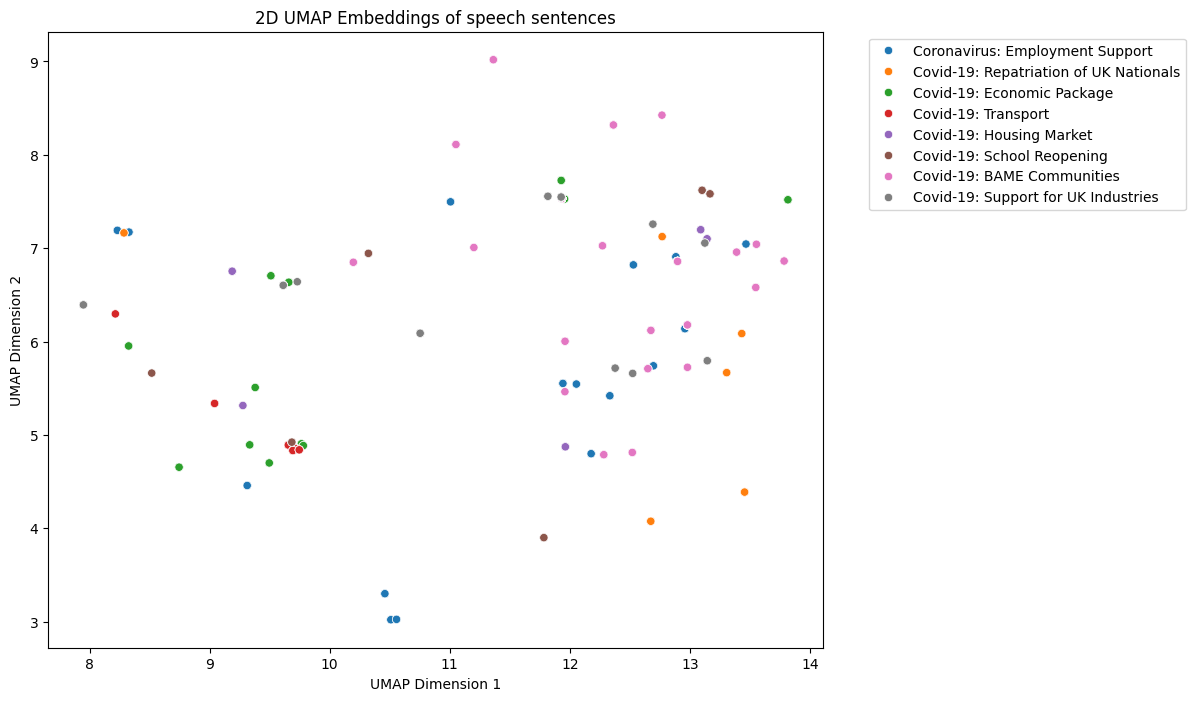

In [63]:
# Create a scatter plot of the 2D embeddings, colored by debate_subject
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[tmp.index, 0], y=embeddings_2d[tmp.index, 1], hue=tmp['debate_subject'], legend='full')
plt.title('2D UMAP Embeddings of speech sentences')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Unfortunately, this is not very informative as eyeballing clusters is really difficult here.

But maybe 2D is just too few dimensions.
Or the debate titles are no good summaries (too generic?) of what speakers talk about.